<a href="https://colab.research.google.com/github/guthi1/reinforcement-learning/blob/main/Assignment_2/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment 2 (133 pts total)

## Instructions:
* This is an individual assignment. You are not allowed to discuss the problems with other students.
* Part of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want.
* All your solution, code, analysis, graphs, explanations should be done in this same notebook.
* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.
* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.

This assignment has three parts. Part 1 will focus on the Monte Carlo method, you will learn:

1. To use the Monte Carlo method for control
2. To use Monte Carlo estimates for off-policy prediction using importance sampling

Part 2 will focus on *prediction*. You will learn:

1. To use Monte Carlo estimates for prediction
2. To use Temporal difference methods for prediction
3. To understand the relationship between the two, and unifying the algorithms

Part 3 will focus on Temporal Difference control methods. You will learn:

1. To use SARSA for optimal control
2. To use ExpectedSARSA for optimal control
3. To use Q-learning for optimal control

In [ ]:
!pip install otter-grader
!git clone https://github.com/chandar-lab/INF8250e-assignments-public.git public
# # Initialize Otter
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/assignment_2_python/tests')

In [2]:
import matplotlib.pyplot as plt

import random
import numpy as np

# Set seed
seed = 10
np.random.seed(seed)
random.seed(seed)
import warnings
warnings.filterwarnings('ignore')

# Environment

Consider a variation of the ```FrozenLake-v0``` environment from the OpenAI gym library. The agent controls the movement of a character in a grid world. Some tiles of the frozen and walkable (```F```), while others are holes in the lake (```H```) that lead to the agent falling into the water. The states are denoted similarly to the GridWorld in assignment 1: $S=\{0,1,2,..., 14, 15\}$ for a 4x4 lake. The agent starts on a starting tile (```S```), and its goal is to find the fastest walkable path to a goal tile (```G```).

The agent can move in the four cardinal directions, $A=\{left, down, right, up\}$, but the floor is slippery! Given a `slip_rate` of $0 \leq \xi < 1$, the agent will go in a random wrong direction with probability $\xi$. 


The reward is $-1$ on all transitions, except for three cases that all result in the episode terminating: (1) The agent falling into a hole nets the agent a reward of $-100$, (2) The agent takes over 100 steps, all the ice melts and the agent gets a reward of $-100$, and (3) The agent reaches the goal state, rewarding it a reward of $0$. The discount factor for this environment should be set to $\gamma = 0.99$. The environment is implemented for you below. 

Example 4x4 FrozenLake environment

|            |            |            |            |
|------------|------------|------------|------------|
| `S`   | `F` |`F` | `F` |
| `F` | `H` | `F` | `H` |
| `F` | `F` |`F` | `H` |
| `H`| `F` | `F` | `G` |





In [4]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils

from gym import Env, spaces
from gym.utils import seeding
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "2x2": ["SF", "HG"],
    "4x4-easy":["SFFF", "FHFF", "FFFF", "HFFG"],
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "6x5": [
        "SFFFF",
        "FFFFF",
        "FHFFF",
        "FHFFF",
        "FFFFF",
        "GFFFF",
    ]
}



def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.random()).argmax()


class DiscreteEnv(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """

    def __init__(self, nS, nA, P, isd, max_length=50):
        self.P = P
        self.isd = isd
        self.lastaction = None  # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.max_length = max_length

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        self.t = 0
        return int(self.s)

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        if self.t >= self.max_length:
            d = True
            r = -100
        self.t += 1
        return (int(s), r, d, {"prob": p})

class FrozenLakeEnv(DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the
    park when you made a wild throw that left the frisbee out in the middle of
    the lake. The water is mostly frozen, but there are a few holes where the
    ice has melted. If you step into one of those holes, you'll fall into the
    freezing water. At this time, there's an international frisbee shortage, so
    it's absolutely imperative that you navigate across the lake and retrieve
    the disc. However, the ice is slippery, so you won't always move in the
    direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self, desc=None, map_name="4x4", slip_rate=0.5):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b"S").astype("float64").ravel()
        isd /= isd.sum()

        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            # reward = float(newletter == b"G")
            reward = -1
            # if newletter == b"H":
            #     reward = -100
            done = False
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter == b"G":
                        li.append((1.0, s, 0, True))
                    if letter == b'H':
                        li.append((1.0, s, -100, True))
                    else:
                        if slip_rate > 0:
                            li.append((slip_rate/2.0, *update_probability_matrix(row, col, (a - 1) % 4)))
                            li.append((1 - slip_rate, *update_probability_matrix(row, col, a)))
                            li.append((slip_rate/2.0, *update_probability_matrix(row, col, (a + 1) % 4)))
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(
                "  ({})\n".format(["Left", "Down", "Right", "Up"][self.lastaction])
            )
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

# Part 0 - Helper Methods (5pts)
First, let us define some helper methods that will be useful for the entire assignment. We give here three methods that may use or not use at any point of the assignment

In [182]:
def random_policy(state):
    """
    Input: state (int) [0, .., 15]
    output: action (int) [0,1,2,3]
    """
    return np.random.randint(0,4)

def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp, mean_exp - std_exp, color=color, alpha=0.1)
    
def random_argmax(value_list):
    """ a random tie-breaking argmax """
    values = np.asarray(value_list)
    return np.argmax(np.random.random(values.shape) * (values==values.max()))

## Question 1 - Creating some helper methods (5pts)



In [6]:
def choose_action(p):
    return np.random.choice(np.arange(len(p)), p=p)

### Question 1a) (2 pts)
Implement an epsilon-greedy policy over the state-action values of an environment.

In [7]:
def make_eps_greedy_policy(state_action_values, epsilon):
    """
    Input:
        state_action_values (list[list]): first axis maps over states of an environment, and second axis the actions.
                                        The stored values are the state-action values corresponding to the state and action index
        epsilon (float): Probability of taking a random action
    Returns policy (int -> int): method taking a state and returning a sampled action to take
    """
    def policy(state):
        # TO IMPLEMENT
        # --------------------------------
        action = None
        if np.random.uniform() >= epsilon:
            # * Exploite the best one so far
            action = random_argmax(state_action_values[state])
        else:
            # * Explore a random one
            action = random_policy(state)
        return action
        # --------------------------------
    return policy

In [8]:
grader.check("question 0.1a")

question 0.1a results: All test cases passed!

### Question 1b) (3 pts)
**b)** Create a function `generate_episode` which takes as input a policy $\pi$ (like the one outputted by **question 1a**), the environment, and the boolean `render` which renders every step of the episode in text form (rendering the episode is as easy as calling `env.render()`). The output of this function should return the tuple $\texttt{states}, \texttt{actions}, \texttt{rewards}$ containing the states, actions, and rewards of the generated episode following $\pi$.

In [9]:
def generate_episode(policy, env, render=False): 
    """
    Input:
        policy (int -> int): policy taking a state as an input and outputs a given action
        env (DiscreteEnv): The FrozenLake environment
        render (bool): Whether or not to render the episode
    Returns:
        states (list): the sequence of states in the generated episode
        actions (list): the sequence of actions in the generated episode
        rewards (list): the sequence of rewards in the generated episode 
    """
    states = []
    rewards = []
    actions = []
    done = False
    # --------------------------------
    current_stage = env.reset()
    states.append(current_stage)
    
    steps = 0
    if render:
        env.render()

    while not done:
        # Do an action base on the policy
        action = policy(current_stage)
        next_state, reward, done, prob = env.step(action)

        if render:
            env.render()
       
        # Save values
        states.append(next_state)
        rewards.append(reward)
        actions.append(action)
        current_stage = next_state

        # Update step number and check limit (2)
        steps += 1
        if steps == 100:
            rewards.append(-100)
            done = True
    # --------------------------------
    return states, actions, rewards

In [10]:
grader.check("question 0.1b")

question 0.1b results: All test cases passed!

# Part 1 - Monte Carlo Methods (27 pts)

Consider in this section the 6x6 version of the FrozenLake environment, with a `slip_rate` of 0.1. Again, make sure to use a discount factor of $\gamma=0.99$ for all your experiments. This environment can be instantiated with `{env = FrozenLakeEnv(map_name="6x6", slip_rate=0.1)`

## Question 1 (15 pts)


### Question 1a) (5pts)
Implement the first-visit Monte Carlo (for $\epsilon$-soft policies) control algorithm to find the approximate optimal policy $\pi \approx \pi_*$.

In [11]:
def fv_mc_estimation(states, actions, rewards, discount):
    """
    Input: 
        states (list): states of an episode generated from generate_episode
        actions (list): actions of an episode generated from generate_episode
        rewards (list): rewards of an episode generated from generate_episode
        discount (float): discount factor
    Returns visited_states_returns (dictionary): 
        keys are all the unique state-action combinations in the episode
        values are the estimated discounted return of the first visited pair
    """
    visited_states_returns = {}
    # TO IMPLEMENT
    # --------------------------------
    def unless_pair_pair(pair: tuple, t: int):
        for i, pair_seen in enumerate(zip(states, actions)):
            if pair == pair_seen:
                return True
            if t == i:
                break
        return False

    G = 0
    for t in range(len(states)-2, -1, -1):
        G = discount*G + rewards[t]
        pair = (states[t], actions[t])
        if unless_pair_pair(pair, t):
            visited_states_returns[pair] = G
    # --------------------------------
    return visited_states_returns

In [12]:
grader.check("question 1.1a")

question 1.1a results: All test cases passed!

Given your implementation of `fv_mc_estimation`, we can now do control. 

In [13]:
def fv_mc_control(env, epsilon=0.05, num_episodes=100, discount=0.99):
    # Initialize memory of estimated state-action returns
    state_action_returns = [[[] for j in range(env.action_space.n)] for i in range(env.observation_space.n)]
    all_returns = []
    
    for j in range(num_episodes):
        state_action_values = [[np.mean(a) for a in s] for s in state_action_returns]
        policy = make_eps_greedy_policy(state_action_values, epsilon)
        states, actions, rewards = generate_episode(policy, env)
        visited_states_returns = fv_mc_estimation(states, actions, rewards, discount)
        for sa in visited_states_returns:
            s, a = sa
            state_action_returns[s][a].append(visited_states_returns[sa])
        all_returns.append(np.sum(rewards))
    
    state_action_values = [[np.mean(a) for a in s] for s in state_action_returns]
    return state_action_values, all_returns

<!-- BEGIN QUESTION -->

### Question 1b) - Plotting (3pts)

Let $\epsilon=0.05$, run the algorithm for 2000 episodes, and repeat this experiment for 5 different runs. Plot the average undiscounted return across the 5 different runs with respect to the number of episodes (x-axis is the 1000 episodes, y-axis is the return for each episode)

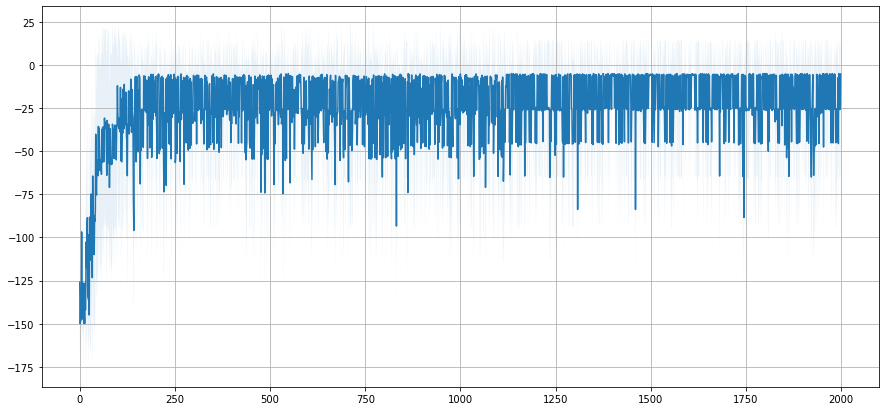

In [14]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)

# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)

all_sa_values, all_returns = [], []
for i in range(5):
    sa_values, returns = fv_mc_control(env, epsilon=0.05, num_episodes=2000)
    all_sa_values.append(sa_values)
    all_returns.append(returns)

plt.figure(figsize=(15,7))
plt.grid()
plot_many(all_returns)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1c) (2 pts)
Visualize an episode during evaluation with the last learned state-action value tables using the code below. For clarity, let's evaluate an episode with `0 slip_rate` and $\epsilon=0$. In the absence of a slip-rate and exploration, what is the return of the optimal policy for all 5 learned state-action value tables?

Type your answer here

In [15]:
# Visualize path
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
optimal_policy = make_eps_greedy_policy(all_sa_values[-1], epsilon=0.)

s, a, r = generate_episode(optimal_policy, env, render=True)


SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF


In [16]:
# Getting the return during evaluation
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
for i in range(5):
    optimal_policy = make_eps_greedy_policy(all_sa_values[i], epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Return is ' + str(np.sum(r)))

Return is -5
Return is -5
Return is -5
Return is -5
Return is -5


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1d) - Plotting again (2pts)
##### Now repeat the exercise from b), but set $\epsilon=0.5$.

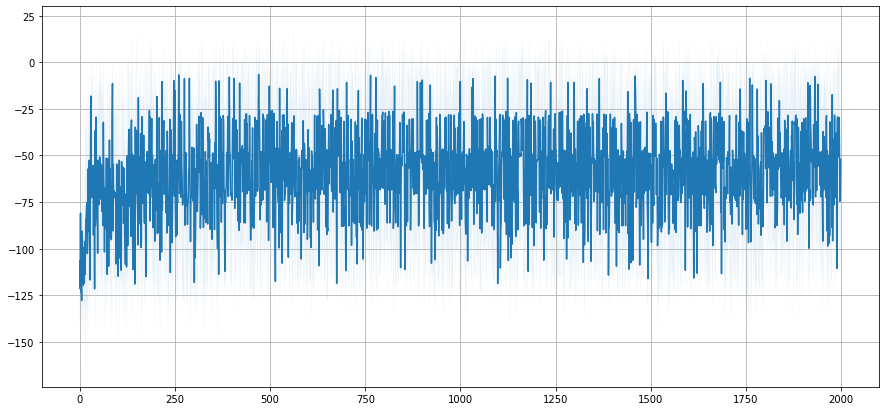

In [17]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)

# Set seed
env.seed(seed)
np.random.seed(seed)
random.seed(seed)

all_sa_values_c, all_returns_c = [], []
for i in range(5):
    sa_values, returns = fv_mc_control(env, epsilon=0.5, num_episodes=2000)
    all_sa_values_c.append(sa_values)
    all_returns_c.append(returns)

plt.figure(figsize=(15,7))
plt.grid()
plot_many(all_returns_c)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e)  (3pts)
 Again, evaluate the policies derived from the learned sate-action value tables under 0 `slip_rate` and $\epsilon=0.$
 You should notice now that some of your learned policies produce returns that are **lower** than the previous optimal return found. Visualize the path taken from one of these "sub-optimal" policies. Why does this happen? Answer in 1 to 3 sentences.  

Type your answer here

In [18]:
# Visualize path taken
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
optimal_policy = make_eps_greedy_policy(all_sa_values_c[-1], epsilon=0.)
s, a, r = generate_episode(optimal_policy, env, render=True)


SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Down)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF
  (Up)
SFFFF
FFFFF
FHFFF
FHFFF
FFFFF
GFFFF


In [19]:
# Get evaluation return 
for i in range(5):
    env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
    optimal_policy = make_eps_greedy_policy(all_sa_values_c[i], epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Return is ' + str(np.sum(r)))

Return is -150
Return is -5
Return is -5
Return is -5
Return is -5


<!-- END QUESTION -->

## Question 2 (12 pts)
Consider a random behavior policy $b(a|s) = 0.25$ for every $a$ and $s$. In this section, we will use episodes generated with $b$ to evaluate the value function of $V^\pi(s)$ for some arbitrary $\pi$.

### Question 2a) (2 pts)
 Before implementing the importance sampling algorithms, let's write a function that returns the epsilon greedy policy with respect to state action values again. But this time, let it return the probability distribution over actions instead of a sampled action. $\pi(a|s): \mathcal{S} \rightarrow \mathbb{R}^{|\mathcal{A}|}$

In [20]:
def make_eps_greedy_policy_distribution(state_action_values, epsilon):
    """
    Input:
        state_action_values (list[list]): first axis maps over states of an environment, and second axis the actions.
                                        The stored values are the state-action values corresponding to the state and action index
        epsilon (float): Probability of taking a random action
    Returns policy (int -> list[float]): method taking a state and returning the 
                                        probability distribution over actions
    """
    def policy(state):
        # TO IMPLEMENT
        # --------------------------------
        n_state = len(state_action_values[state])
        pr_dist_action = np.ones(n_state)
        # Assign the odds of choosing a random action
        pr_dist_action = pr_dist_action * epsilon / n_state
        # Add the ods of chosing the best one
        max_state = np.argmax(state_action_values[state])
        pr_dist_action[max_state] += 1 - epsilon
        return pr_dist_action
        # --------------------------------
    return policy

In [21]:
grader.check("question 1.2a")

question 1.2a results: All test cases passed!

### Question 2b) (5 pts)
Implement the `is_mc_estimate_with_ratios` method that computes all importance sampling estimates of the states of an episode of a given target policy given the random behavior policy. Let it also return all the associated importance sampling ratios. **DO NOT USE AN INCREMENTAL IMPLEMENTATION**

In [22]:
def is_mc_estimate_with_ratios(states, actions, rewards, target_policy, discount):
    """
    Input: 
        states (list): states of an episode generated from generate_episode
        actions (list): actions of an episode generated from generate_episode
        rewards (list): rewards of an episode generated from generate_episode
        target_policy (int -> list[float]): The target policy that takes in a state and returns 
                                            an action probability distrtibution
        discount (float): discount factor
    Returns states_returns_and_ratios (dictionary): 
        Keys are all the states visited in the input episode
        Values is a list of tuples. The first index of the tuple is the IS estimate of the discounted returns
            of that state in the episode. The second index is the IS ratio associated with each of the IS estimates. 
                i.e: if state 2 is visited 3 times in the episode, 
                state_returns_and_ratios[2] should be a list of 3 tuples.
    """
    
    # TO IMPLEMENT
    # --------------------------------
    # Init visited states list        
    state_returns_and_ratios = {state : [] for state in states}
    # Discounted returns
    G = 0.0
    # Importance smapling
    IS_ratio = 1.0 
    # Loop the step
    for t in range(len(states)-2, -1, -1):    
        state, action, reward = states[t], actions[t], rewards[t]  
        # Update discount
        G = discount*G + reward
        # Find ratio
        IS_ratio = IS_ratio * ((target_policy(state)[action])/(1/len(target_policy(state))))
        IS_estimate_discount = G * IS_ratio
        state_returns_and_ratios[state].insert(0, (IS_estimate_discount, IS_ratio))
    # --------------------------------
    return state_returns_and_ratios

In [23]:
grader.check("question 1.2b")

question 1.2b results: All test cases passed!

Given the off-policy importance sampling estimates, we can now perform Ordinary and weighted importance sampling.

In [24]:
def ois_mc_pred(env, b_policy, target_policy, num_episodes, discount=0.99):
    state_returns = [[] for i in range(env.observation_space.n)]
    value_function_trace = []
    
    for j in (range(num_episodes)):
        states, actions, rewards = generate_episode(b_policy, env)
        sra = is_mc_estimate_with_ratios(states, actions, rewards, target_policy, discount)
        for s in sra:
            for ra in sra[s]:
                state_returns[s].append(ra[0])
        value_function_trace.append([np.mean(s) for s in state_returns])
    return value_function_trace

def wis_mc_pred(env, b_policy, target_policy, num_episodes, discount=0.99):
    state_returns = [[] for i in range(env.observation_space.n)]
    all_ratios = [[] for i in range(env.observation_space.n)]
    value_function_trace = []
    
    for j in (range(num_episodes)):
        states, actions, rewards = generate_episode(b_policy, env)
        sra = is_mc_estimate_with_ratios(states, actions, rewards, target_policy, discount)
        for s in sra:
            for ra in sra[s]:
                state_returns[s].append(ra[0])
                all_ratios[s].append(ra[1])
        value_function_trace.append([np.sum(s)/np.sum(all_ratios[i]) for i,s in enumerate(state_returns)])
    return value_function_trace

Now we use *ordinary importance sampling* Monte Carlo prediction and *weighted importance sampling* Monte Carlo prediction to evaluate the $V^\pi(s)$ for one of the epsilon-greedy policies learned in **2b)**. In both cases, the algorithm is run for 1000 episodes across 3 runs.

In [25]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)

policy = make_eps_greedy_policy_distribution(all_sa_values[0], 0.05)

all_value_function_traces_ois = []
for i in range(5):
    value_function_trace = ois_mc_pred(env, random_policy, policy, 1000)
    all_value_function_traces_ois.append(value_function_trace)

all_value_function_traces_wis = []
for i in range(5):
    value_function_trace = wis_mc_pred(env, random_policy, policy, 1000)
    all_value_function_traces_wis.append(value_function_trace)

<!-- BEGIN QUESTION -->

### Question 2c) - Plotting and Analysis (5pts)
Plot the average off policy Monte Carlo estimates of $V^\pi(s)$ for some specified states against the number of episodes for both *ordinary importance sampling* and *weighted importance sampling*. In theses plots, the standard deviation is included as a confidence band. Which of the two methods do you expect to produce lower variance estimates, and why?

Type your answer here

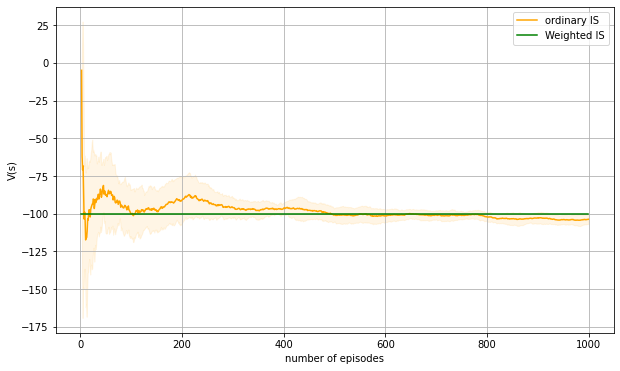

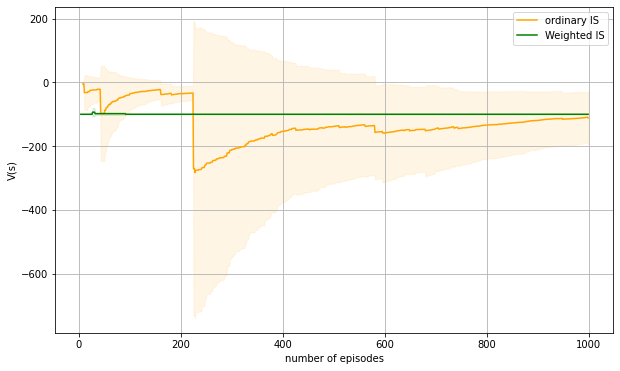

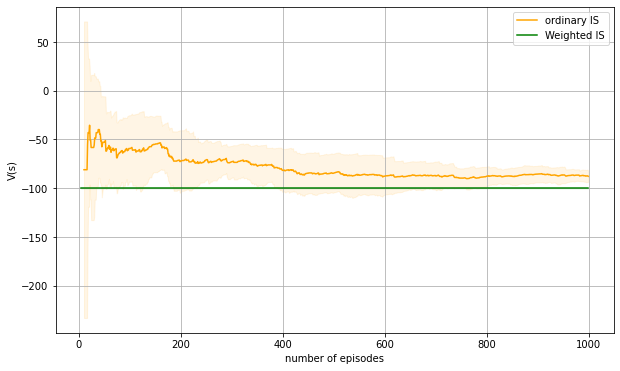

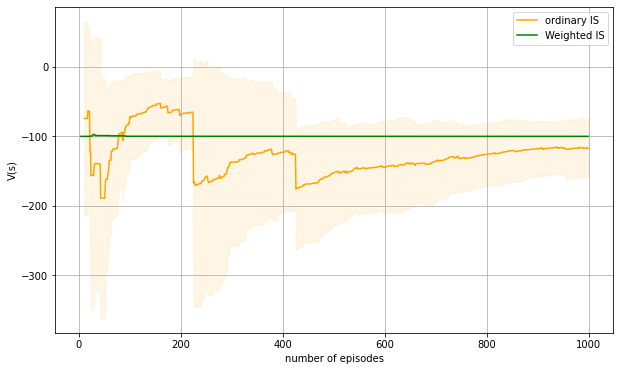

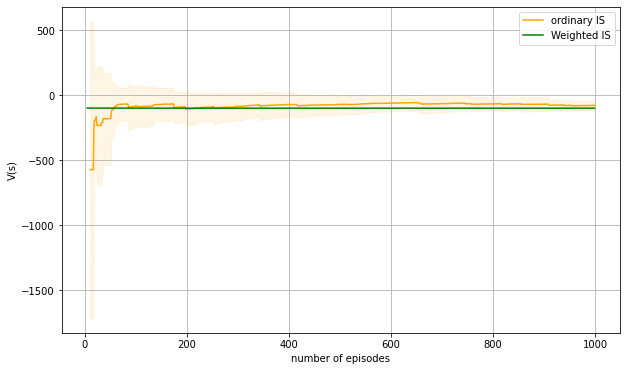

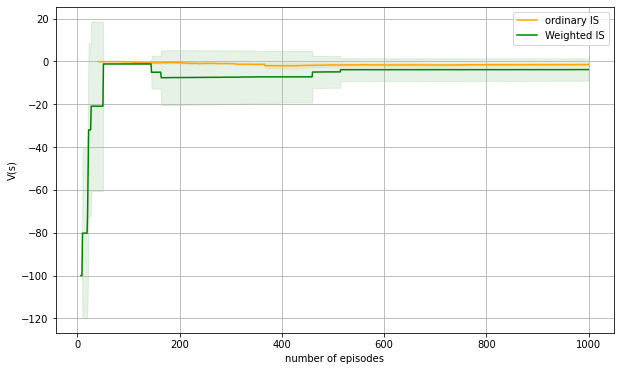

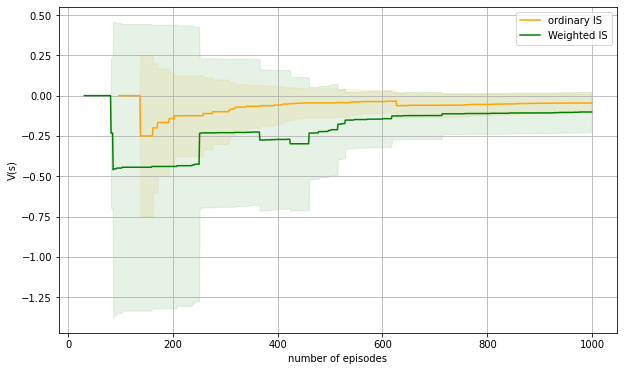

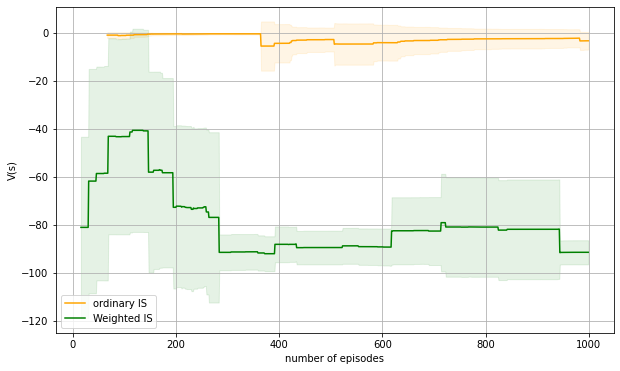

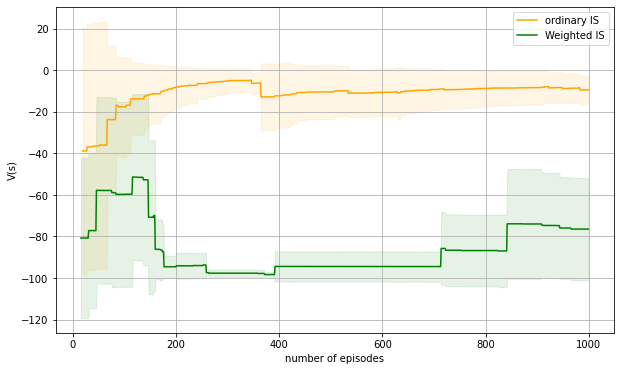

In [26]:
for state in [11, 12, 16, 17, 18, 20, 25, 27, 28]:
    plt.figure(figsize=(10,6))
    plot_many(np.array(all_value_function_traces_ois)[:,:,state], color='orange', label='ordinary IS')
    plot_many(np.array(all_value_function_traces_wis)[:,:,state], color='green', label='Weighted IS')
    plt.xlabel('number of episodes')
    plt.ylabel('V(s)')
    plt.grid()
    plt.legend()


<!-- END QUESTION -->

# Part 2 -  Prediction: Unifying Monte Carlo methods and Temporal Difference Learning (54 pts)

Consider in this section the same 6x5 FrozenLake environment with a `slip_rate` of 0.1. Use a discount factor of $\gamma=0.99$. We will be working with the same random policy used above for all questions in this part: $\pi(a|s) = 0.25$ for all $a$ and $s$. 

## Question 1 - MC (10 pts)


### Question 1a) (5 pts)
Implement the *Every visit Monte Carlo prediction* algorithm in order to estimate $V^\pi(s)$.

In [27]:
def ev_mc_estimate(states, actions, rewards, discount):
    """
    Input: 
        states (list): states of an episode generated from generate_episode
        actions (list): actions of an episode generated from generate_episode
        rewards (list): rewards of an episode generated from generate_episode
        discount (float): discount factor
    Returns visited_states_returns (dictionary): 
        Keys are all the states visited in an the given episode
        Values is a list of the estimated MC return of a given state. 
            i.e: if a state is visited 3 times in an episode, there are 3 estimated returns of that state.
    """
    visited_state_returns = {state:[] for state in states}
    # TO IMPLEMENT 
    # --------------------------------
    G = 0
    for t in range(len(states)-2, -1, -1):    
        state, action, reward = states[t], actions[t], rewards[t]  
        # Update discount
        G = discount*G + reward
        visited_state_returns[state].insert(0, G)
    # --------------------------------
    return visited_state_returns

In [28]:
grader.check("question 2.1a")

question 2.1a results: All test cases passed!

We now use `ev_mc_estimate` to do prediction

In [29]:
def ev_mc_pred(policy, env, num_episodes=100, discount=0.99):
    state_returns = [[0] for i in range(env.observation_space.n)]
    state_values_trace = []
    for j in (range(num_episodes)):
        states, actions, rewards = generate_episode(policy, env)
        visited_state_returns = ev_mc_estimate(states, actions, rewards, discount)
        for s in visited_state_returns:
            state_returns[s].extend(visited_state_returns[s])
        state_values_trace.append([np.mean(s) for s in state_returns])
    return state_values_trace

<!-- BEGIN QUESTION -->

### Question 1b) - Plotting (5 pts)
 Train the algorithm for 10000 episodes, and plot the learning curves for each $s$ of $V^\pi(s)$ over the number of episodes. The result should be 1 figure, with 16 curves plotted inside it (one for each state, x-axis is the 10000 episodes, y-axis is the current estimate of $V^\pi(s)$)

In [30]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
ev_state_vals = ev_mc_pred(random_policy, env, num_episodes=10000, discount=0.99)

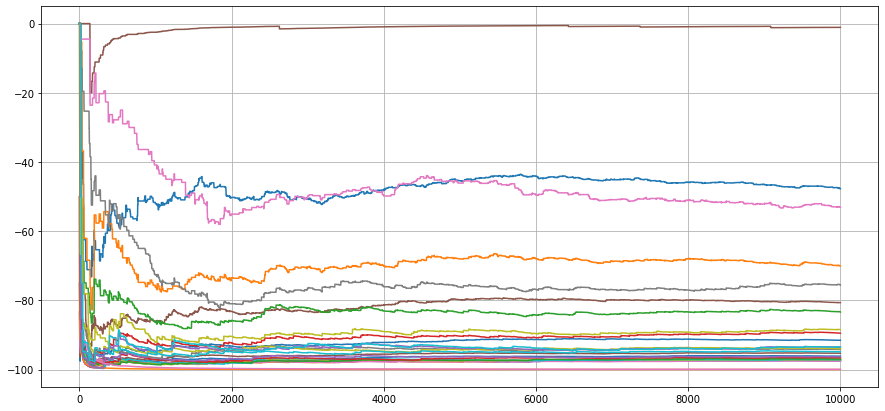

In [31]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ev_state_vals)

<!-- END QUESTION -->

## Question 2 - TD(0) (10 pts)

### Question 2a) (5 pts)
Implement the `TD(0)` prediction algorithm to estimate $V^\pi(s)$.

In [32]:
def td0(policy, env, step_size=0.1, num_episodes=100, discount=0.99):
    """
    Input: 
        policy (int -> int): policy to evaluate
        env (DiscreteEnv): FrozenLake environment 
        step_size (float): step size alpha of td learning
        num_episodes (int): number of episodes to run the algorithm for
        discount (float): discount factor
    Returns state_values_trace (list of lists):
        Value estimates of each state at every episode of training.
    
    Do not modify state_values_trace. JUST UPDATE state_values.
        state_values keep tracks of the value of each state. Each index of state_values represents one state.
    """
    state_values = [0 for i in range(env.observation_space.n)]
    state_values_trace = []
    for j in (range(num_episodes)):
        # --------------------------------
        # Init S
        state = env.reset()
        next_action = policy(state)

        # Take action
        while True:
            # Take action, observe R, S'
            next_state, reward, done, prob = env.step(next_action)

            # V(S) <- V(S) + alpha[R + discount*V(S') - V(S)]
            if not done:
                state_values[state] += step_size*(reward + discount*state_values[next_state] -  state_values[state])
            else:
                state_values[state] += step_size*(reward -  state_values[state])

            # S <- S'
            state = next_state

            # Choose next action
            next_action = policy(next_state)

            if done:
                break
        # --------------------------------
        state_values_trace.append([s for s in state_values])
    return state_values_trace

In [33]:
grader.check("question 2.2a")

question 2.2a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2b) - Plotting (5 pts)
Use a step size $\alpha=0.01$. Train the algorithm for 10000 episodes as well, and plot the same figure as in the previous question ($V^\pi(s)$ for each $s$ over the number of episodes).

In [34]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
td_state_vals = td0(random_policy, env, step_size=0.01, num_episodes=10000)

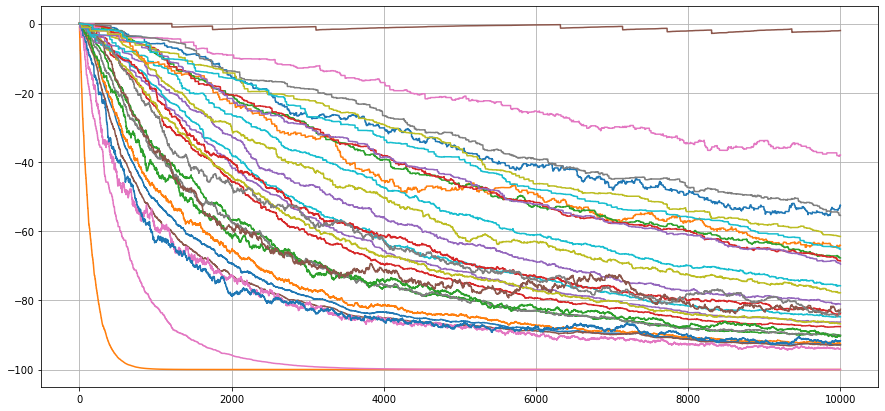

In [35]:
plt.figure(figsize=(15,7))
plt.plot(td_state_vals)
plt.grid()

<!-- END QUESTION -->

## Question 3 - TDN (15 pts)

### Question 3a) (5pts)

Now, implement the *n-step* `TD` algorithm to estimate $V^\pi(s)$. 

In [248]:
def tdn(policy, env, n, step_size=0.1, num_episodes=100, discount=0.99):
    """
    Input: 
        policy (int -> int): policy to evaluate
        env (DiscreteEnv): FrozenLake environment
        n (int): Number of steps before bootstrapping for td(n) algorithm
        step_size (float): step size alpha of td learning
        num_episodes (int): number of episodes to run the algorithm for
        discount (float): discount factor
    Returns state_values_trace (list of lists):
        Value estimates of each state at every episode of training.
    
    Do not modify state_values_trace. JUST UPDATE state_values.
        state_values keep tracks of the value of each state. Each index of state_values represents one state.
    """
    state_values = [0 for i in range(env.observation_space.n)]
    state_values_trace = []
    n += 1
    for j in (range(num_episodes)):
        # TO IMPLEMENT
        # --------------------------------
        # Reset Env
        st = env.reset()
        states = [st]
        rewards = [0]
        actions = []
        # Init variable
        T = np.inf
        t = 0

        while True:
            if t < T:
                # Take action according to pi(*|S_t)
                ac = policy(st)
                actions.append(ac)
                st, rd, done, _ = env.step(ac)
                rewards.append(rd)
                states.append(st)

                if done:
                    # print(f"Done [t={t}]")
                    T = t + 1

            rho = t - n + 1 # Time whose state's estimate is being updated

            if rho >= 0:
                G = 0
                for i in range(rho+1, min(rho+n+1, T+1)):
                    G += (discount**(i-rho-1)) * rewards[i]
                if rho+n < T:
                    G +=(discount**n) * state_values[states[rho+n]]
                state_values[states[rho]] += step_size*(G - state_values[states[rho]])
            if rho == T-1:
                break
            t += 1
        # --------------------------------
        state_values_trace.append([s for s in state_values])
    return state_values_trace

In [249]:
grader.check("question 2.3a")

question 2.3a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 3b) - Plotting (2 pts)
Use a step size of $\alpha=0.01$. This algorithm should take the additional hyper-parameter $n$ to determine how much to bootstrap. Now set $n=0$, and train the algorithm for 10000 episodes. Plot the the same figure as before ($V^\pi(s)$ for each $s$ over the number of episodes)

In [250]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
tdn1_state_vals = tdn(random_policy, env, n=0, step_size=0.01, num_episodes=10000)

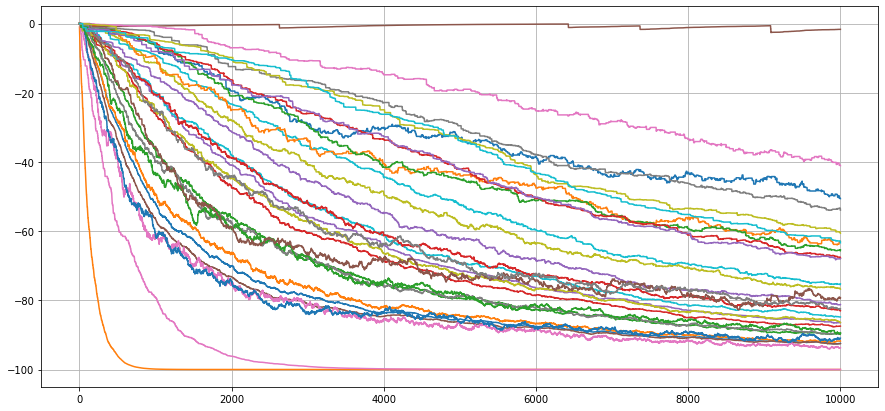

In [251]:
plt.figure(figsize=(15,7))
plt.plot(tdn1_state_vals)
plt.grid()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3c) (3 pts)
Compare this figure to `TD(0)` and *Every visit Monte Carlo Prediction*. Which algorithm do you expect this figure to look similar to? Does it, why or why not?

Type your answer here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3d) - Plotting (2 pts)
Using the same implementation of *n-step* `TD`, estimate $V^\pi(s)$ using $n = 100$ instead (still with $\alpha=0.01$ and 10000 episodes). Again, plot the same figure as before ($V^\pi(s)$ for each $s$ over the number of episodes).

In [252]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
tdn100_state_vals = tdn(random_policy, env, n=100, step_size=0.01, num_episodes=10000)

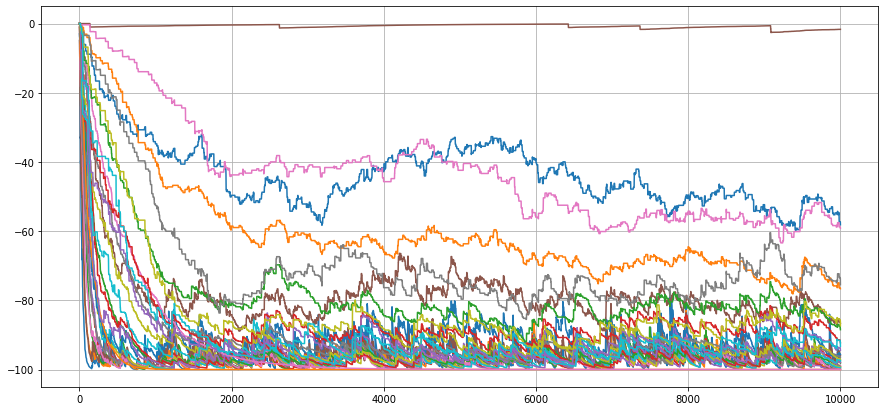

In [253]:
plt.figure(figsize=(15,7))
plt.plot(tdn100_state_vals)
plt.grid()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3e)  (3 pts)
Compare this new figure to `TD(0)` and *Every visit Monte Carlo Prediction*. Which algorithm do you expect this figure to look similar to? Does it, why or why not?

Type your answer here

<!-- END QUESTION -->

# Question 4 - Unifying (9 pts)

The intuition is that *n-step* `TD` should generalize both *Monte Carlo prediction* and `TD(0)`. We saw in the previous question that it does not seem to be equivalent to MC prediction. Modify your *n-step* `TD` algorithm such that when $n=100$, it becomes equivalent to *Every visit Monte Carlo prediction*. Hint: This has to do with the step size $\alpha$.

<!-- BEGIN QUESTION -->

### Question 4a) (3 pts)
Before implementing this modified `TDN`, identify what the new formula for $\alpha$ should be.

Type your answere here

<!-- END QUESTION -->

### Question 4b) (3 pts)
Now implement the `modified_tdn` method that uses this new step size. Most of this method is the same as `tdn`.

In [308]:
def modified_tdn(policy, env, n, num_episodes=100, discount=0.99):
    """
    This function should largely be equivalent to the tdn function implemented in Question 3.
    The only difference is the step size will be dynamically changed using your formula in Q5a).
    You may copy paste most lines in the previous implementation.
    
    Input: 
        policy (int -> int): policy to evaluate
        env (DiscreteEnv): FrozenLake environment
        n (int): Number of steps before bootstrapping for td(n) algorithm
        step_size (float): step size alpha of td learning
        num_episodes (int): number of episodes to run the algorithm for
        discount (float): discount factor
    Returns state_values_trace (list of lists):
        Value estimates of each state at every episode of training.
    
    Do not modify state_values_trace. JUST UPDATE state_values and state_visitation.
        state_values keep tracks of the value of each state. Each index of state_values represents one state.
    """
    state_values = [0 for i in range(env.observation_space.n)]
    state_visitation = [0 for i in range(env.observation_space.n)]
    state_values_trace = []
    n += 1
    for j in (range(num_episodes)):
        # TO IMPLEMENT
        # --------------------------------
        # Reset Env
        st = env.reset()
        states = [st]
        rewards = [0]
        actions = []
        state_visitation[st] += 1
        # Init variable
        T = np.inf
        t = 0

        while True:
            if t < T:
                # Take action according to pi(*|S_t)
                ac = policy(st)
                actions.append(ac)
                st, rd, done, _ = env.step(ac)
                rewards.append(rd)
                states.append(st)
                state_visitation[st] += 1


                if done:
                    # print(f"Done [t={t}]")
                    T = t + 1

            rho = t - n + 1 # Time whose state's estimate is being updated

            if rho >= 0:
                G = 0
                for i in range(rho+1, min(rho+n+1, T+1)):
                    G += (discount**(i-rho-1)) * rewards[i]
                if rho+n < T:
                    G +=(discount**n) * state_values[states[rho+n]]
                state_values[states[rho]] += (1/state_visitation[states[rho]]) * (G - state_values[states[rho]])
            if rho == T-1:
                break
            t += 1
        # --------------------------------
        state_values_trace.append([s for s in state_values])
    return state_values_trace

In [309]:
grader.check("question 2.4b")

question 2.4b results:
    question 2.4b - 1 result:
        ❌ Test case failed
        Trying:
            answers = {1: [-12.14359154, -15.00479634, -16.76559563, -18.03477267,
                   -19.02451728, -19.83416103, -20.51819894, -21.10973223,
                   -21.6303582 , -22.09493901, -22.51413286, -22.89583936,
                   -23.24607351, -23.5695194 , -23.86989476, -24.15019889,
                   -24.412886  , -24.65998929, -24.89321175, -25.11399375],
                      10: [-50.34716411, -58.28996713, -62.60144165, -65.46553558,
                   -67.5675138 , -69.2058335 , -70.5354492 , -71.64637001,
                   -72.59515746, -73.41949171, -74.14563424, -74.79255955,
                   -75.37438652, -75.90188156, -76.38342658, -76.82566406,
                   -77.23393969, -77.61261395, -77.96528619, -78.29495916],
                      45: [-96.29357908, -98.03394659, -98.64911857, -98.96608494,
                   -99.16014544, -99.29150293, -99.3864821 , -99.4584462 ,
                   -99.51491004, -99.56042854, -99.59792566, -99.62936565,
                   -99.65611767, -99.67916568, -99.69923528, -99.71687348,
                   -99.73250054, -99.74644477, -99.75896643, -99.77027451]}
               
                        
        Expecting nothing
        ok
        Trying:
            env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
        Expecting nothing
        ok
        Trying:
            dummy_state_action_values = np.arange(30*4).reshape(30,4)
        Expecting nothing
        ok
        Trying:
            dummy_pi = make_eps_greedy_policy(dummy_state_action_values, 0.)
        Expecting nothing
        ok
        Trying:
            for n in [1, 10, 45]:
                dummy_state_vals = modified_tdn(dummy_pi, env, n=n, num_episodes=20)
                np.testing.assert_allclose(np.array(answers[n]), np.array(dummy_state_vals)[:,0], atol=1e-2)
        Expecting nothing
        **********************************************************************
        Line 23, in question 2.4b 0
        Failed example:
            for n in [1, 10, 45]:
                dummy_state_vals = modified_tdn(dummy_pi, env, n=n, num_episodes=20)
                np.testing.assert_allclose(np.array(answers[n]), np.array(dummy_state_vals)[:,0], atol=1e-2)
        Exception raised:
            Traceback (most recent call last):
              File "/usr/lib/python3.7/doctest.py", line 1337, in __run
                compileflags, 1), test.globs)
              File "<doctest question 2.4b 0[4]>", line 3, in <module>
                np.testing.assert_allclose(np.array(answers[n]), np.array(dummy_state_vals)[:,0], atol=1e-2)
              File "/usr/local/lib/python3.7/dist-packages/numpy/testing/_private/utils.py", line 1531, in assert_allclose
                verbose=verbose, header=header, equal_nan=equal_nan)
              File "/usr/local/lib/python3.7/dist-packages/numpy/testing/_private/utils.py", line 844, in assert_array_compare
                raise AssertionError(msg)
            AssertionError: 
            Not equal to tolerance rtol=1e-07, atol=0.01

            Mismatched elements: 20 / 20 (100%)
            Max absolute difference: 2.72010607
            Max relative difference: 0.2885294
             x: array([-12.143592, -15.004796, -16.765596, -18.034773, -19.024517,
                   -19.834161, -20.518199, -21.109732, -21.630358, -22.094939,
                   -22.514133, -22.895839, -23.246074, -23.569519, -23.869895,
                   -24.150199, -24.412886, -24.659989, -24.893212, -25.113994])
             y: array([ -9.424381, -12.28469 , -14.055481, -15.334982, -16.334165,
                   -17.152283, -17.84394 , -18.442366, -18.969272, -19.439615,
                   -19.864127, -20.250769, -20.605607, -20.933366, -21.237797,
                   -21.521928, -21.788238, -22.038781, -22.275276, -22.49918 ])

<!-- BEGIN QUESTION -->

### Question 4c) - Plotting (3 pts)
Now plot the same plot as in the previous questions with $n=100$, and compare it with the *Every Visit MC prediction* algorithm. You should now see that their behaviors match.

In [ ]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
mod_tdn100_state_vals = modified_tdn(random_policy, env, n=100, num_episodes=10000)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(mod_tdn100_state_vals)
plt.grid()

<!-- END QUESTION -->

# Question 5 - Bias-variance tradeoff (10 pts)
Finally, we have (at least practically) shown that *n-step* `TD` unifies `TD(0)` and *MC prediction*. Let's further examine how these two algorithms differ.


### Question 5a) (3 pts)
Let's implement some metric to evaluate the error of our value estimates. For this question, you can simply compute the mean squared error with the mean value of the last 100 $V^\pi(s)$ learned for each experiment. If $i$ is the $i$th episode, and $V^\pi_i(s)$ is the value function at that episode, then `mse`$(V^\pi_i(s))=\texttt{mean}((V^\pi_i(s) - \text{mean}(V^\pi_{-100:10000})^2, \texttt{axis=-1})$.

In [ ]:
def value_mse(values):
    """
    Input: 
        values (list[lists]): The output of the tdn method, state_values_trace
    Output:
        np.array, output of the above function described in Question 6a)
    """
    # TO IMPLEMENT
    # --------------------------------
    ...
    # --------------------------------

In [ ]:
grader.check("question 2.5a")

<!-- BEGIN QUESTION -->

### Question 5b) - Plotting (2 pts)
We will use the original *n-step* `TD` algorithm (with a fixed $\alpha$) to plot the mean squared errors during learning with $n=1, n=10$, and $n=100$ over 10000 episodes. Do this for $\alpha=0.5$, $\alpha=0.1$, and $\alpha=0.01$. There should be three figures (one for each $\alpha$), each containing three plots (the three values of $n$).

In [ ]:
env = FrozenLakeEnv(map_name="6x5", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)

td0_state_vals_alpha001 = tdn(random_policy, env, n=0, step_size=0.01, num_episodes=10000)
td10_state_vals_alpha001 = tdn(random_policy, env, n=10, step_size=0.01, num_episodes=10000)
td100_state_vals_alpha001 = tdn(random_policy, env, n=100, step_size=0.01, num_episodes=10000)

td0_state_vals_alpha01 = tdn(random_policy, env, n=0, step_size=0.1, num_episodes=10000)
td10_state_vals_alpha01 = tdn(random_policy, env, n=10, step_size=0.1, num_episodes=10000)
td100_state_vals_alpha01 = tdn(random_policy, env, n=100, step_size=0.1, num_episodes=10000)

td0_state_vals_alpha05 = tdn(random_policy, env, n=0, step_size=0.5, num_episodes=10000)
td10_state_vals_alpha05 = tdn(random_policy, env, n=10, step_size=0.5, num_episodes=10000)
td100_state_vals_alpha05 = tdn(random_policy, env, n=100, step_size=0.5, num_episodes=10000)

In [ ]:
figure, axis = plt.subplots(3, 1, figsize=(10, 15))

axis[0].plot(value_mse(td0_state_vals_alpha001), label='n=0')
axis[0].plot(value_mse(td10_state_vals_alpha001), label='n=10')
axis[0].plot(value_mse(td100_state_vals_alpha001), label='n=100')
axis[0].grid(alpha=0.5)
axis[0].legend()

axis[1].plot(value_mse(td0_state_vals_alpha01), label='n=0')
axis[1].plot(value_mse(td10_state_vals_alpha01), label='n=10')
axis[1].plot(value_mse(td100_state_vals_alpha01), label='n=100')
axis[1].grid(alpha=0.5)
axis[1].legend()

axis[2].plot(value_mse(td0_state_vals_alpha05), label='n=0')
axis[2].plot(value_mse(td10_state_vals_alpha05), label='n=10')
axis[2].plot(value_mse(td100_state_vals_alpha05), label='n=100')
axis[2].grid(alpha=0.5)
axis[2].legend()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

 ### Question 5 c) (5 pts)
 Using this visualization, explain the bias-variance trade-off of temporal difference methods versus Monte Carlo methods. (Don't worry if the figures for $\alpha=0.1$ and especially $\alpha=0.5$ are too noisy, this is just a qualitative inspection).

Type your answer here

<!-- END QUESTION -->

# Part 3 - Temporal Difference Control Methods (47 pts)

Continuing with the same FrozenLake environment as before with 0 `slip_rate` this time, we will investigate various TD-control methods in this section. In this question you need to implement a training procedure similar to the `generate_episode` function in Part 0, but instead of running a fixed policy, you need to ensure that the agent is trained (i.e., value estimate is updated) throughout the learning phase. 

First, carefully read and understand the code provided for a base class that will serve as the parent class for all learning agents you will implement in this section. 

In [ ]:
class Agent():
    def __init__(self):
        pass
        
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        np.random.seed(agent_init_info['seed'])
        random.seed(agent_init_info['seed'])
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions))
    
    def get_current_policy(self):
        """
        Returns the epsilon greedy policy of the agent following the previous implementation of 
        make_eps_greedy_policy
        
        Returns:
            Policy (callable): fun(state) -> action
        """
        return make_eps_greedy_policy(self.q, epsilon=self.epsilon)
    
    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        """ A learning step for the agent given a state, action, reward, next state and done
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done 
        Returns: 
            action (int): the action the agent is taking given current_state
        """
        raise NotImplementedError


## Question 1 - Helper methods (3 pts)

Implement the method `train_episode`, that is similar in function to the `generate_episode`, except it takes an agent as an argument instead of the policy, and simultaneously trains the agent while generating an episode. (Hint, make use of the `agent_step` method of the `Agent` class to both get an action and train the agent.)

In [ ]:
def train_episode(agent, env):
    """
    Input:
        agent (Agent): an agent of the class Agent implemented above
        env (DiscreteEnv): The FrozenLake environment
    Returns:
        states (list): the sequence of states in the generated episode
        actions (list): the sequence of actions in the generated episode
        rewards (list): the sequence of rewards in the generated episode 
    """
    states = []
    rewards = []
    actions = []
    done = False
    current_state = env.reset()
    states.append(current_state)
    action = agent.get_current_policy()(current_state)
    actions.append(action)
    while not done:
        # TO IMPLEMENT
        # --------------------------
        ...
        # --------------------------
    return states, actions, rewards

In [ ]:
grader.check("question 3.1")

We then provide the code to train an agent using this newly written method. 

In [ ]:
def td_control(agent_class, epsilon, step_size, run, num_episodes=100, discount=0.99):
    agent_info = {
        "num_actions": 4,
        "num_states": 30,
        "epsilon": epsilon,
        "step_size": step_size,
        "discount": discount,
        "seed": run
        }
    agent = agent_class()
    agent.agent_init(agent_info)
    
    env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
    # Set seed
    seed = run
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    all_returns = []
    
    for j in (range(num_episodes)):
        states, actions, rewards = train_episode(agent, env)
        all_returns.append(np.sum(rewards))
        
    return all_returns, agent

# Question 2 - SARSA (8 pts)



## Question 2a) (5 pts)
Implement the SARSA control algorithm. Recall the update rule given $S, A, R, S', A'$:

$$Q(S,A) \leftarrow Q(S, A) + \alpha \left[ R+ \gamma Q(S', A') - Q(S,A) \right]$$

And make sure to handle terminal states correctly.

In [ ]:
class SarsaAgent(Agent):
    
    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        """ A learning step for the agent given SARS
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done 
        Returns: 
            action (int): the action the agent is taking given current_state
        """
        # TO IMPLEMENT
        # --------------------------
        ...
        # --------------------------

        return action
    

In [ ]:
grader.check("question 3.2a")

<!-- BEGIN QUESTION -->

### Question 2b) - Evaluating (3 pts)

Let's run the SARSA algorithm on our 0 slip rate environment. We set $\epsilon=0.5$, $\alpha=0.1$, $\gamma=0.99$, and run the algorithm 5 times over 2000 episodes.

In [ ]:
## Running SARSA on the environment on 5 different seeds

epsilon = 0.5 #@param {allow-input: true}
step_size = 0.1 #@param {allow-input: true}
discount = 0.99 #@param
num_runs =  5 #@param {allow-input: true}
num_episodes = 2000 #@param {allow-input: true}

sarsa_returns = []
sarsa_agents = []
for i in range(num_runs):
    returns, agent = td_control(agent_class=SarsaAgent, epsilon=epsilon, step_size=step_size, run=i, num_episodes=num_episodes, discount=discount)
    sarsa_returns.append(returns)
    sarsa_agents.append(agent)

Now let's evaluate our agents with 0 exploration.

In [ ]:
## Evaluating the agent with 0 exploration, i.e epsilon=0

sarsa_optimal_returns = []
for i in range(num_runs):
    env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
    optimal_policy = make_eps_greedy_policy(sarsa_agents[i].q, epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Optimal return for seed {0} is {1}'.format(i, np.sum(r)))
    sarsa_optimal_returns.append(np.sum(r))

<!-- END QUESTION -->

## Question 3 - Expected Sarsa (8 pts)

### Question 3a) (5 pts)
Implement the Expected SARSA control aglorithm. Recall the update rule:
$$Q(S,A) \leftarrow Q(S,A) + \alpha \left[ R + \gamma \mathbb{E}_{a\sim\pi} [Q(S', a|S')] - Q(S,A)\right]$$
And make sure to handle terminal states correctly

In [ ]:
#@title ExpectedSarsa

class ExpectedSarsaAgent(Agent):
    
    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        """ A learning step for the agent given SARS
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done 
        Returns: 
            action (int): the action the agent is taking given current_state
        """
        # TO IMPLEMENT
        # --------------------------
        ...
        # --------------------------
        return action

In [ ]:
grader.check("question 3.3a")

<!-- BEGIN QUESTION -->

### Question 3b) - Evaluating (3 pts)

Let's run the expected SARSA algorithm on our 0 slip rate environment. We set $\epsilon=0.5$, $\alpha=0.1$, $\gamma=0.99$, and run the algorithm 5 times over 2000 episodes.

In [ ]:
## Running Expected SARSA on the environment on 5 different seeds

epsilon = 0.5 #@param {allow-input: true}
step_size = 0.1 #@param {allow-input: true}
discount = 0.99 #@param
num_runs =  5 #@param {allow-input: true}
num_episodes = 2000 #@param {allow-input: true}

esarsa_returns = []
esarsa_agents = []
for i in range(num_runs):
    returns, agent = td_control(agent_class=ExpectedSarsaAgent, epsilon=epsilon, step_size=step_size, run=i, num_episodes=num_episodes, discount=discount)
    esarsa_returns.append(returns)
    esarsa_agents.append(agent)

Again, we evaluate the algorithm with 0 exploration

In [ ]:
## Evaluating the agent with 0 exploration, i.e epsilon=0

esarsa_optimal_returns = []
for i in range(num_runs):
    env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
    optimal_policy = make_eps_greedy_policy(esarsa_agents[i].q, epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Optimal return for seed {0} is {1}'.format(i, np.sum(r)))
    esarsa_optimal_returns.append(np.sum(r))

<!-- END QUESTION -->

## Question 4 - Q-learning (8 pts)


### Question 4a) (5 pts)
Implement the Q-learning control algorithm. Recall the update rule:
$$Q(S,A) \leftarrow Q(S, A) + \alpha \left[ R + \gamma \max_a Q(S', a) - Q(S,A) \right]$$

And make sure to handle terminal states correctly

In [ ]:
#@title Qlearning

class QLearningAgent(Agent):
    
    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        """ A learning step for the agent given SARS
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done 
        Returns: 
            action (int): the action the agent is taking given current_state
        """
        # TO IMPLEMENT
        # --------------------------
        ...
        # --------------------------
        
        return action

In [ ]:
grader.check("question 3.4a")

<!-- BEGIN QUESTION -->

### Question 4b) -  Evaluating (3 pts)

Let's run the Q-learning algorithm on our 0 slip rate environment. We set $\epsilon=0.5$, $\alpha=0.1$, $\gamma=0.99$, and run the algorithm 5 times over 2000 episodes.

In [ ]:
## Running Q-learning on the environment on 5 different seeds

epsilon = 0.5 #@param {allow-input: true}
step_size = 0.1 #@param {allow-input: true}
discount = 0.99 #@param
num_runs =  5 #@param {allow-input: true}
num_episodes = 2000 #@param {allow-input: true}

q_returns = []
q_agents = []
for i in range(num_runs):
    returns, agent = td_control(agent_class=QLearningAgent, epsilon=epsilon, step_size=step_size, run=i, num_episodes=num_episodes, discount=discount)
    q_returns.append(returns)
    q_agents.append(agent)

Again, we evaluate the agent with 0 exploration

In [ ]:
## Evaluating the agent with 0 exploration, i.e epsilon=0

q_optimal_returns = []
for i in range(num_runs):
    env = FrozenLakeEnv(map_name="6x5", slip_rate=0.)
    optimal_policy = make_eps_greedy_policy(q_agents[i].q, epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Optimal return for seed {0} is {1}'.format(i, np.sum(r)))
    q_optimal_returns.append(np.sum(r))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 5 - Plotting everything (5 pts)

###### Now let us plot the learning curves of our algorithms, and their final optimal returns given a deterministic policy. 

In [ ]:
def moving_avg(stuff, window):
    return np.convolve(stuff, np.ones(window)/window, mode='valid')

plt.figure(figsize=(15,7))
plot_many([moving_avg(r, 10) for r in sarsa_returns], label='sarsa', color='purple')
plot_many([moving_avg(r, 10) for r in q_returns], label='q-learning', color='green')
plot_many([moving_avg(r, 10) for r in esarsa_returns], label='expected_sarsa', color='orange')
plt.hlines([np.mean(q_optimal_returns)], -100, 2100, color='green')
plt.hlines([np.mean(sarsa_optimal_returns)], -100, 2100, color='purple')
plt.hlines([np.mean(esarsa_optimal_returns)], -100, 2100, color='orange')
plt.legend()
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('return')

<!-- END QUESTION -->

## Question 6 - Analysis (15 pts)
 

<!-- BEGIN QUESTION -->

### Question 6a) (5 pts)
Which of the three algorithms do you expect to perform better *on-policy*, and why? 

Type your answer here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Quesiton 6b) (5 pts)
Despite the worse learning curve of *Q-learning*, why does it seem to have a better optimal return during evaluation? 

Type your answer here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Quesiton 6c) (5 pts)
Which algorithm was quicker to run between Expected SARSA and SARSA? Why?

Type your answer here

<!-- END QUESTION -->

